In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.decomposition import PCA

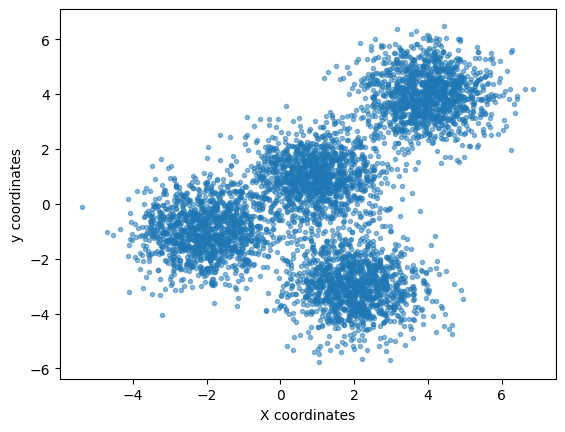

In [228]:
np.random.seed(0)

# 5000 points divided equally among clusters, centres as specified, and standard deviation of 0.9
X, y = make_blobs(n_samples=5000, centers=[[4,4], [-2, -1], [2, -3], [1, 1]], cluster_std=0.9)

# marker gives the shape of each point, in this case a small dot. alpha controls the transparency
plt.scatter(X[:,0], X[:,1],  marker='.', alpha=0.5)
plt.xlabel("X coordinates")
plt.ylabel("y coordinates")
plt.show()

In [229]:
# initialisation is k-means++ by default. n_init: how often k-means is run with different initial centroids. Keeps the best result.
kmeans = KMeans(n_clusters=4, n_init=12)

In [230]:
kmeans.fit(X)
kmeans_labels = kmeans.labels_
kmeans_cluster_centers = kmeans.cluster_centers_

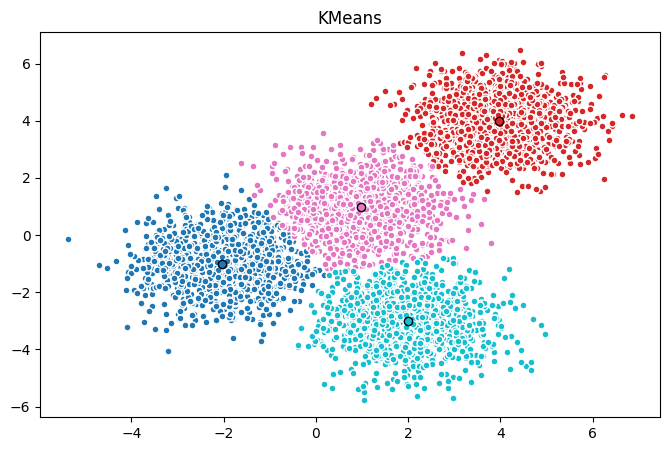

In [231]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

colors = plt.cm.tab10(np.linspace(0, 1, len(set(kmeans_labels))))


for k, col in zip(range(len([[4, 4], [-2, -1], [2, -3], [1, 1]])), colors):
    my_members = (kmeans_labels == k)

    cluster_center = kmeans_cluster_centers[k]

    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.',ms=10)

    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

ax.set_title('KMeans')
plt.show()

In [232]:
cust_df = pd.read_csv(
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%204/data/Cust_Segmentation.csv"
)
cust_df

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2
...,...,...,...,...,...,...,...,...,...,...
845,846,27,1,5,26,0.548,1.220,NaN,NBA007,6.8
846,847,28,2,7,34,0.359,2.021,0.0,NBA002,7.0
847,848,25,4,0,18,2.802,3.210,1.0,NBA001,33.4
848,849,32,1,12,28,0.116,0.696,0.0,NBA012,2.9


In [241]:
# Sum the number of Na's in each column
number_of_na_before = cust_df.isna().sum().sum()

# drop the Na's from our dataset
cust_df.dropna(inplace=True)
number_of_na_after = cust_df.isna().sum().sum()

print(f"number of Na before: {number_of_na_before}, number of Na after: {number_of_na_after}")

number of Na before: 0, number of Na after: 0


In [244]:
X_numerical = [feature for feature in cust_df.columns if cust_df[feature].dtype != "O"]
X_categorical = [feature for feature in cust_df.columns if cust_df[feature].dtype == "O"]

preprocessing = ColumnTransformer([
    ("scale", StandardScaler(), X_numerical),
    ("encode", OneHotEncoder(drop="first", sparse_output=False), X_categorical)
])

pipe = Pipeline([
    ("preprocessing", preprocessing),
    ("classifier", KMeans(n_clusters=4, n_init=12))
])

k_means = pipe.fit(cust_df)
k_means["classifier"].inertia_

4399.528344633843

     k      inertia  silhouette  calinski_harabasz  davies_bouldin
0    2  5551.881324    0.278094         171.624863        1.741837
1    3  4836.775552    0.195860         149.883375        1.715014
2    4  4393.862895    0.175987         133.223053        1.742474
3    5  4098.585299    0.130995         119.479415        1.801268
4    6  3827.194625    0.134519         112.056649        1.754972
5    7  3626.877795    0.135020         104.775280        1.672973
6    8  3425.973464    0.135425         100.733767        1.680878
7    9  3270.017104    0.137233          96.331810        1.658830
8   10  3179.447344    0.141044          90.123961        1.717238
9   11  3083.101539    0.129070          85.678146        1.740226
10  12  3011.814364    0.136120          81.097474        1.722273
11  13  2934.867234    0.125945          77.678512        1.739235
12  14  2873.466875    0.118135          74.256373        1.770135
13  15  2792.861616    0.123401          72.251113        1.73

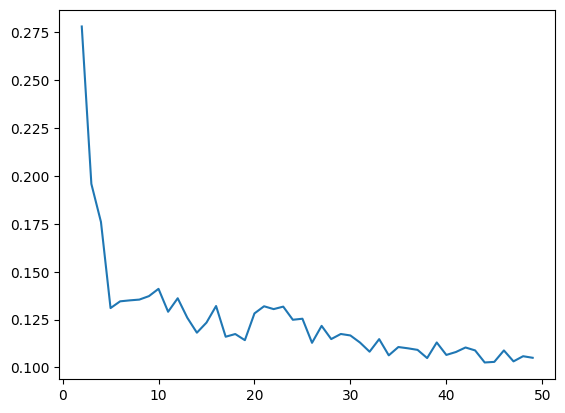

In [251]:
def evaluate_k(k):
    model = Pipeline([
        ("preprocessing", preprocessing),                 # reuse your ColumnTransformer
        ("classifier", KMeans(n_clusters=k, n_init=12, random_state=0)),
    ])
    model.fit(cust_df)
    Xt = model["preprocessing"].transform(cust_df)
    y  = model["classifier"].labels_
    return {
        "k": k,
        "inertia": model["classifier"].inertia_,
        "silhouette": metrics.silhouette_score(Xt, y),
        "calinski_harabasz": metrics.calinski_harabasz_score(Xt, y),
        "davies_bouldin": metrics.davies_bouldin_score(Xt, y),
    }

results = pd.DataFrame([evaluate_k(k) for k in range(2, 50)])
print(results)


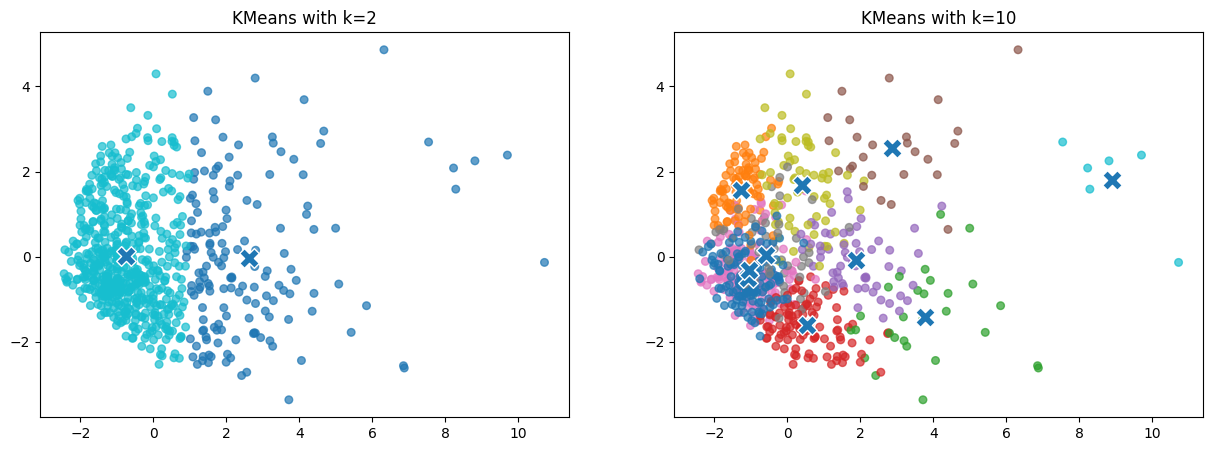

In [267]:
def plot_kmeans_clusters(k, ax):
    model = Pipeline([
        ("preprocessing", preprocess),
        ("classifier", KMeans(n_clusters=k, n_init=12, random_state=0)),
    ])
    model.fit(cust_df)

    # Transform data for visualization
    X_trans = model["preprocessing"].transform(cust_df)

    # Reduce to 2D for plotting
    pca = PCA(n_components=2, random_state=0)
    X_pca = pca.fit_transform(X_trans)

    centroids_pca = pca.transform(model["classifier"].cluster_centers_)
    labels = model["classifier"].labels_

    # Plot data points first
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10",s=30, alpha=0.7)

    # Plot centroids on top
    ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, edgecolor='white')

    ax.set_title(f"KMeans with k={k}")

# Side-by-side plots for k=2 and k=10
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_kmeans_clusters(2, axes[0])
plot_kmeans_clusters(10, axes[1])
plt.show()
